In [1]:
import gurobipy as gb
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from matplotlib import cm
from itertools import chain
from gurobipy import GRB

from utils import data_reader as dr
from utils import problem_model as pm


# Extra

In this part we try to add some further considerations about the models studied so far

## About agents' symmetry

In section 3.3. the authors of the paper said:
>    _"Of note, the increased convergence time may be a result of not only the increase in problem size,
>    but added symmetry within the problem between the homogeneous agents with identical source and termini nodes."_

In this part we investigate if lowering the symettry between agents' source and termini will speed-up the problem solutions. For simplicity we'll consider only the MSPP-PD-ABP problem

In [ ]:
networks_df = dr.read_networks_csv("data/d_it_ij_6x6_1000it.csv",
                                   along="rows")

networks_df.head()


Define data

In [ ]:
network_shape = (6, 6)
network_nodes = pm.get_nodes(networks_df)
num_instances = 5

symmetry_levels = ["high", "medium", "low"]
idx_of_symmetry_lvl = dict(zip(symmetry_levels, range(len(symmetry_levels))))

scenarios = [3, 6, 9, 12]
idx_of_scenario = dict(zip(scenarios, range(len(scenarios))))

convergence_time_shape = (num_instances,
                          len(symmetry_levels),
                          len(scenarios))
convergence_times = np.zeros(convergence_time_shape)


Fix seed of the random number generator, that will be used to generate random agents' sources and terminus

In [ ]:
random.seed(0)


In [ ]:
for it_i, network_arcs in enumerate(pm.network_instances(networks_df.head(num_instances))):

    for num_of_agents in scenarios:

        for symmetry_lvl in symmetry_levels:

            agents = pm.generate_agents(network_shape,
                                        num_of_agents,
                                        symmetry=symmetry_lvl)

            pb, X, *_ = pm.set_problem("ABP",
                                       network_nodes, network_arcs, agents)
            pb.optimize()

            if pb.Status == GRB.OPTIMAL:
                convergence_times[it_i,
                                  idx_of_symmetry_lvl[symmetry_lvl],
                                  idx_of_scenario[num_of_agents]] = pb.Runtime
            else:
                print(f"Something bad occurred for {symmetry_lvl=} in {it_i=}")


If desired we can store results in order to avoid waiting for computations each time we run the notebook

In [ ]:
np.save(
    f"results/agent_symmetries_convergence_times_{num_instances}.npy", convergence_times)


In [ ]:
convergence_times = np.load(
    f"results/agent_symmetries_convergence_times_{num_instances}.npy")


In [ ]:
avg_convergence_times = np.mean(convergence_times, axis=0)

avg_convergence_times_df = pd.DataFrame(avg_convergence_times,
                                        index=symmetry_levels,
                                        columns=scenarios)

avg_convergence_times_df

Interestingly, if all agents have the same source and terminus nodes, the MSPP-PD(ABP) require more or less the same time to be solved independently on the number of agents that has to be routed.

About the relationship between mean convergence time and symmetry of the problem we can state:

- If all agents start from the same source node and end in the same terminus node, the problem size does not change the mean convergence time;

- If all agent source nodes and terminus nodes are selected randomly from the first and last network columns respectively, the mean convergence time stop increasing after a certain problem size;

- If source node and terminus node of agents follows a more sophisticated pattern as the one described in the paper then the mean convergemce time increase with the problem size.


## A possible real case application

Assume to have a facility where humans and robots work together.  
Robots have to move on predefined traks marked on the floor, this tracks form a $(m \times n)$ grid-like system. Each grid's link has 2 direction of travel and if 2 robots follow opposite directions on the same link there is no risk of head-on collision. On the other hand if more robots follow the same direction on the same link, collisions may occur. Each of them has to reach some terminus location in one of the crossroads of the track grid inside the plant where is required to perform some task.  
We want to find the shortest path to the terminus location for each robot minimizing both the risk of robot-robot and human-robot collision.  

This problem can be solved as a MSPP-PD one, below we'll see how


Assume that tracks' grid has size $(10 \times 10)$


In [2]:
num_horiz_tracks, num_vert_tracks = 10, 10


We label with a number each crossroads of the grid. This points will form the nodes of the network on which we'll formulate the MSPP-PD problem and represent possible starting or terminus locations of robots


In [3]:
facility_network_nodes = np.arange(num_horiz_tracks * num_vert_tracks)
facility_nodes_grid = np.arange(
    num_horiz_tracks * num_vert_tracks).reshape(num_vert_tracks, num_horiz_tracks).T

facility_nodes_grid


array([[ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
       [ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91],
       [ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92],
       [ 3, 13, 23, 33, 43, 53, 63, 73, 83, 93],
       [ 4, 14, 24, 34, 44, 54, 64, 74, 84, 94],
       [ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95],
       [ 6, 16, 26, 36, 46, 56, 66, 76, 86, 96],
       [ 7, 17, 27, 37, 47, 57, 67, 77, 87, 97],
       [ 8, 18, 28, 38, 48, 58, 68, 78, 88, 98],
       [ 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]])

The arcs of our network will be formed by the directed links of the grid.  
Their weights will indicate how much human-congestioned is a particular link so that while solving the MSPP-PD we'll penalize robot paths that traverse areas full of human workers in order to avoid possible accidents between them and robots


In [4]:
def get_facility_instance(network_nodes_grid, weight_func):

    num_rows, num_cols = network_nodes_grid.shape

    weast_to_east_arcs = ((network_nodes_grid[i, j], network_nodes_grid[i, j+1], weight_func(i, j+1/2))
                          for j in range(num_cols-1) for i in range(num_rows))

    east_to_west_arcs = ((network_nodes_grid[i, j+1], network_nodes_grid[i, j], weight_func(i, j+1/2))
                         for j in range(num_cols-1) for i in range(num_rows))

    north_to_south_arcs = ((network_nodes_grid[i, j], network_nodes_grid[i+1, j], weight_func(i+1/2, j))
                           for j in range(num_cols) for i in range(num_rows-1))

    south_to_north_arcs = ((network_nodes_grid[i+1, j], network_nodes_grid[i, j], weight_func(i+1/2, j))
                           for j in range(num_cols) for i in range(num_rows-1))

    all_arcs = chain(weast_to_east_arcs, east_to_west_arcs,
                     north_to_south_arcs, south_to_north_arcs)

    return [pm.WArc(i, j, w, idx) for idx, (i, j, w) in enumerate(all_arcs)]


For our example we suppose that that most of the work carried out by humans has to be performed at the center of the plant.  


In [5]:
def congested_center_weigth_func(x, y):
    x_term = (x - ((num_horiz_tracks-1)/2))**2 / \
        (2 * ((num_horiz_tracks-1)/6)**2)
    y_term = (y - ((num_vert_tracks-1)/2))**2 / \
        (2 * ((num_vert_tracks-1)/6)**2)
    return 1.5 * math.exp(-(x_term+y_term)) + 1


We could also visualize how arcs weight change among the facility


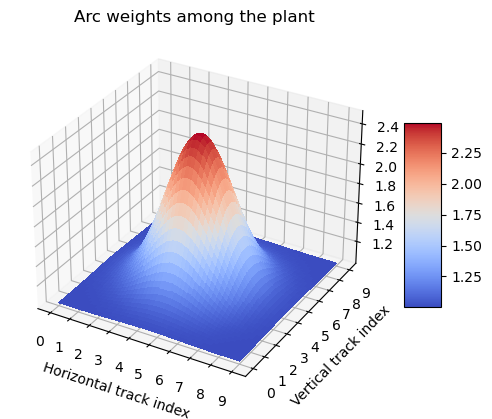

In [6]:
x = np.linspace(0, num_horiz_tracks-1, 100)
y = np.linspace(0, num_vert_tracks-1, 100)
X, Y = np.meshgrid(x, y)

Z = np.vectorize(congested_center_weigth_func)(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('Horizontal track index')
plt.xticks(range(num_horiz_tracks))
ax.set_ylabel('Vertical track index')
plt.yticks(range(num_vert_tracks))
ax.set_title('Arc weights among the plant')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


Now we can generate the arcs for our example


In [7]:
facility_network_arcs = get_facility_instance(facility_nodes_grid, congested_center_weigth_func)


Robots are the agents that has to be routed in our MSPP-PD.  
For our example we assume:
- of having to route 20 different robots;
- that they are, at the beginning, scattered within the facility;
- that each one has to reach different (random) locations where they have to perform tasks.


In [8]:
def generate_random_agents(network_nodes, num_of_agents):
    '''
    Agents sources and terminus are picked at random from the nodes of the networks
    '''

    agent_idxs = list(range(num_of_agents))
    agents = []

    while agent_idxs:
        agent_source = random.choice(network_nodes)
        agent_terminus = random.choice(network_nodes)
        if agent_source != agent_terminus:
            agents.append(
                pm.Agent(agent_source, agent_terminus, agent_idxs.pop(0)))

    return agents


# generate agents for our  example
robots = generate_random_agents(facility_network_nodes, 20)


Now everything is ready to define the arcs of our instance and to formulate the MSPP-PD problem for our practical scenario


In [9]:
facility_pb, X, *_ = pm.set_problem("ABP", facility_network_nodes, facility_network_arcs, robots)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-10


Now we can solve the problem...


In [10]:
facility_pb.optimize()


And print the solution if the optimum is found


In [11]:
print("Result of the optimization is:")
if facility_pb.Status == 2:
    print("optimal")
elif facility_pb.Status == 3:
    print("infeasible")
elif facility_pb.Status == 5:
    print("unbounded")
else:
    print("Some other return status")


Result of the optimization is:
optimal


In [12]:
for agent in robots:
    print(f"Agent {agent.idx} will follow the path:")
    for arc in facility_network_arcs:
        if math.isclose(X.x[arc.idx, agent.idx], 1):
            print(f"{arc.i}->{arc.j}", end="\t")
    print()


Agent 0 will follow the path:
13->23	23->33	14->13	
Agent 1 will follow the path:
1->11	11->21	21->31	31->41	41->51	51->61	61->71	0->1	71->72	72->73	73->74	
Agent 2 will follow the path:
16->6	26->16	36->26	2->1	3->2	4->3	5->4	6->5	37->36	38->37	
Agent 3 will follow the path:
59->49	58->59	
Agent 4 will follow the path:
0->10	10->20	20->30	30->40	40->50	50->60	60->70	70->80	80->81	81->82	82->83	83->84	
Agent 5 will follow the path:
38->28	48->38	58->48	68->58	78->68	88->78	85->86	86->87	87->88	
Agent 6 will follow the path:
69->59	79->69	89->79	99->89	59->58	
Agent 7 will follow the path:
49->39	59->49	69->59	77->67	67->68	68->69	74->75	75->76	76->77	
Agent 8 will follow the path:
33->23	43->33	53->43	23->24	
Agent 9 will follow the path:
29->19	39->29	49->39	59->49	69->59	
Agent 10 will follow the path:
6->16	16->26	26->36	36->46	46->56	56->66	66->76	76->86	86->96	
Agent 11 will follow the path:
59->49	48->47	49->48	
Agent 12 will follow the path:
32->42	42->52	52->62	33->32	34->33	35